In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('atlantic.csv')

###cleaning data###
df = df[df.iloc[:,10]!=-999]
df['Latitude'] = df['Latitude'].str.replace('[a-zA-Z]','').astype(float)
df['Longitude'] = df['Longitude'].str.replace('[a-zA-Z]','').astype(float)
df['Longitude'] = -1*df['Longitude'] #since the longtitude is in the west

# strip white space and create status list
df['Name'] = df['Name'].apply(lambda x: x.strip())
df['Status_Str'] = df['Status'].loc[:]
df['Status'] = df['Status'].apply(lambda x: x.strip())
status_list = list(pd.unique(df['Status']))
print(status_list)

status_dict = {'TD': 'Tropical cyclone of tropical depression intensity (< 34 knots)',  
               'TS': 'Tropical cyclone of tropical storm intensity (34-63 knots) ', 
               'HU': 'Tropical cyclone of hurricane intensity (> 64 knots)',  
               'EX': 'Extratropical cyclone (of any intensity)',  
               'SD': 'Subtropical cyclone of subtropical depression intensity (< 34 knots)',  
               'SS': 'Subtropical cyclone of subtropical storm intensity (> 34 knots)',  
               'LO': 'A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)',  
               'WV': 'Tropical Wave (of any intensity)  DB – Disturbance (of any intensity)' }

# make the status an integer value for classification
for i in range(len(status_list)):
    df['Status'].replace(status_list[i], i, inplace=True)
    
df.head()

['TD', 'TS', 'HU', 'EX', 'WV', 'LO', 'SS', 'SD', 'DB']


/var/folders/p7/fsjbmc_s7tj5x1xnwwn4mtg8rxv65f/T/ipykernel_26585/2953702390.py:9: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/p7/fsjbmc_s7tj5x1xnwwn4mtg8rxv65f/T/ipykernel_26585/2953702390.py:10: FutureWarning:

The default value of regex will change from True to False in a future version.



,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Status_Str
43104,AL012004,ALEX,20040731,1800,,0,30.3,-78.3,25,1010,...,0,0,0,0,0,0,0,0,0,TD
43105,AL012004,ALEX,20040801,0,,0,31.0,-78.8,25,1009,...,0,0,0,0,0,0,0,0,0,TD
43106,AL012004,ALEX,20040801,600,,0,31.5,-79.0,25,1009,...,0,0,0,0,0,0,0,0,0,TD
43107,AL012004,ALEX,20040801,1200,,0,31.6,-79.1,30,1009,...,0,0,0,0,0,0,0,0,0,TD
43108,AL012004,ALEX,20040801,1800,,1,31.6,-79.2,35,1009,...,0,0,0,0,0,0,0,0,0,TS


In [680]:
# create array of hurricane ids
np.random.seed(0)
hurricane_ids = pd.unique(df[df['Status']==2]['ID'])

# save ids of 80% of hurricanes for training
training_hurricanes = np.random.choice(hurricane_ids, size=int(hurricane_ids.shape[0]*0.8), replace=False)
# save remaining 20% for testing
test_hurricanes = np.setdiff1d(hurricane_ids, training_hurricanes)

In [681]:
# build training sets of hurricanes
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

columns = ['ID', 'Latitude', 'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW']

dfx = df[df['Time'].isin([0, 600, 1200, 1800])][columns]
data = dfx.to_numpy()
data_feat = data[:, 3:]
data_label = data[:, 1:3] # lat/lon
scaler_feat = MinMaxScaler() #Scaling with MinMaxScaler method
scaler_labels = MaxAbsScaler()
data[:, 1:3] = scaler_labels.fit_transform(data[:, 1:3])
data[:, 3:] = scaler_feat.fit_transform(data[:, 3:])

training_feat_sets = []
training_label_sets = []
for i in training_hurricanes: 
    d = data[data[:, 0] == i]
    # no need to sort by time, df already sorted 
    feat = d[:, 1:]
    feat = feat.astype(np.float)
    labels = d[:, 1:3]
    labels = labels.astype(np.float)
    training_feat_sets.append(feat)
    training_label_sets.append(labels)   
    
test_feat_sets = []
test_label_sets = []
for i in test_hurricanes: 
    d = data[data[:, 0] == i]
    # no need to sort by time, df already sorted 
    feat = d[:, 1:]
    feat = feat.astype(np.float)
    labels = d[:, 1:3]
    labels = labels.astype(np.float)
    test_feat_sets.append(feat)
    test_label_sets.append(labels)   


In [821]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Activation, TimeDistributed, Bidirectional, Dropout, ConvLSTM2D, Flatten, LeakyReLU
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator

# simple model
def build_model():
    model = Sequential()
    model.add(LSTM(5, input_shape=(5, 16),return_sequences=True, recurrent_activation='tanh', recurrent_dropout=0.2))
    model.add(Dense(2))

    model.compile(loss="mse", optimizer="rmsprop")
    return model

In [815]:
# 2-Stacked model

def build_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(None, 16),return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(50, return_sequences=True, recurrent_dropout=0.2))
    model.add(Dense(2))

    model.compile(loss="mse", optimizer="rmsprop")
    return model

In [822]:
model = build_model()
for feats, labels in zip(training_feat_sets, training_label_sets):
    generator = TimeseriesGenerator(feats, labels, length=5, batch_size=1, reverse=False) 
    model.fit(generator, epochs=5, verbose=0)  # BEST EPOCHS = 4

In [823]:
# print MSE of last hurricane used as test set
train_score = model.evaluate(generator, verbose=0)
print(f'Train Score: {train_score:.4f} MSE')

Train Score: 0.0004 MSE


In [828]:

preds = {i:{'pred':None, 'hold':None, 'score':None, 'test': None} for i in range(len(test_feat_sets))}
for i, (feats, labels) in enumerate(zip(test_feat_sets, test_label_sets)):
    test_feat_input, _ = np.array_split(feats, 2)
    test_label_input, test_label_hold = np.array_split(labels, 2)
    preds[i]['hold'] = test_label_hold
    preds[i]['test'] = test_label_input
#     if test_feat_input.shape[0] > 2:
    test_feat_input = test_feat_input[-5:, None,:] # take latest 4 observations -> predict next 4 
    preds[i]['score'] = model.evaluate(test_feat_input, test_label_hold[-5:, :], verbose=0)
    preds[i]['pred'] = model.predict(test_feat_input)

        
# test_score = model.evaluate(x_test, y_test_latitude, verbose=0)
# print('Test Score: %.4f MSE' % (testScore))

In [829]:
test_mse = 0
for i in preds:
    test_mse += preds[i]['score']
print(f'Test MSE = {test_mse}')

Test MSE = 0.748479406000115


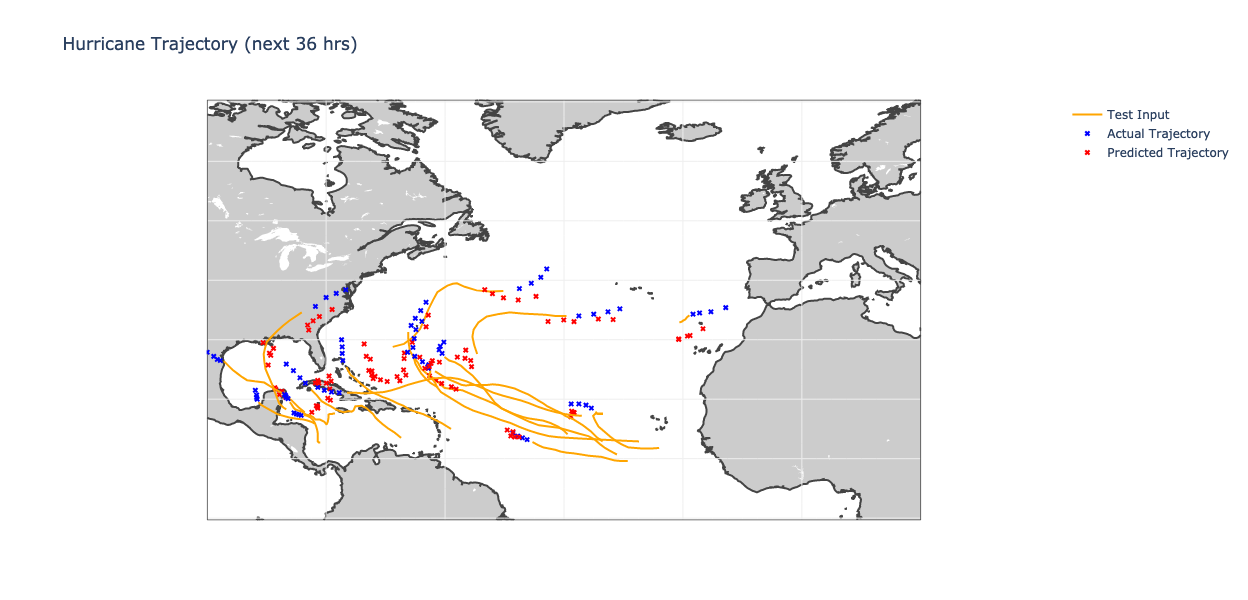

In [833]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()

for i in range(len(test_hurricanes)):
    
#     legend_bool = 
    
    if isinstance(preds[i]['pred'], type(None)):
        continue
    coords = scaler_labels.inverse_transform(preds[i]['hold'])
    test_coords = scaler_labels.inverse_transform(preds[i]['test'])
    pred_coords = preds[i]['pred'][:, 0, :]
    pred_coords = scaler_labels.inverse_transform(pred_coords)
    fig.add_trace(go.Scattergeo(
        lat = test_coords[:, 0],
        lon = test_coords[:, 1],
        mode = 'lines',
        line = dict(
            width=2,
            color = 'orange',
        ), name='Test Input', showlegend = True if i==0 else False,
    ))
    fig.add_trace(go.Scattergeo(
        lat = coords[:4, 0],
        lon = coords[:4, 1],
        mode = 'markers',
        marker = dict(
            size=5,
            color = 'blue',
            symbol='x'
        ), name='Actual Trajectory', showlegend = True if i==0 else False,
    ))

    fig.add_trace(go.Scattergeo(
    lat = pred_coords[:, 0],
    lon = pred_coords[:, 1],
    mode = 'markers',
    marker = dict(
        size=5,
        color = 'red',
        symbol='x'
    ), name='Predicted Trajectory', showlegend = True if i==0 else False,
))

fig.update_layout(
width=1000, height=600,
title_text = 'Hurricane Trajectory (next 36 hrs)',
geo = dict(
    resolution = 50,
    showland = True,
    showlakes = True,
    landcolor = 'rgb(204, 204, 204)',
    countrycolor = 'rgb(204, 204, 204)',
    lakecolor = 'rgb(255, 255, 255)',
    projection_type = "equirectangular",
    coastlinewidth = 2,
    lataxis = dict(
        range = [0, 70],
        showgrid = True,
        dtick = 10
    ),
    lonaxis = dict(
        range = [-100, 20],
        showgrid = True,
        dtick = 20
    ),))
    
fig.show()
